# The Multi-Color Prophet Problem notebook

 Contact: p.praat@student.uva.nl

In [11]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.stats import uniform
from numpy.random import default_rng
from collections import Counter
import matplotlib.pyplot as plt
from statistics import mean
import pandas as pd

from numpy import save
from numpy import load

from tqdm import tqdm # for the progress bar

_We next consider the following multi-color prophet problem. In this model n candidates arrive in uniform random order. Candidates are partitioned into k groups $C = {C_1,···,C_k}$. We write $n=(n1,...,nk)$ for the vector of groupsizes, i.e., $|C_j| = n_j$ ,for all 1 ≤ j ≤ k. We identify each of the groups with a distinct color and let c(i), vi denote the color and value of candidate i, respectively. The value vi that is revealed upon arrival of i, and is drawn independently from a given distribution Fi. We use $F = (F_1, . . . , Fn)$ to refer to the vector of distributions. We are also given a probability vector $p = (p_1, . . . , p_k)$. The goal is to select a candidate in an online manner in order to maximize the expectation of the value of the selected candidate, while selecting from each color with probability proportional to p. We distinguish between the basic setting in which $p_j$ is the proportion of candidates that belong to group j, i.e., $p_j = n_j/n$, and the general setting in which $p$ is arbitrary. We compare ourselves with the fair optimum, the optimal offline algorithm that respects the $p_j$ ’s._

## The two algorithms presented in the paper

In [3]:
def middleBinomial(n):
    n_candidates = n
    n = 1000
    p = 0.5 #probability of coin succeeding
    choose = np.zeros((n+1,n+1)) # creating 'choose' variable -> number of combinations per number of successes
    for i in range(n+1):
        choose[i,0] = 1

    for i in range(1,n+1):
        for j in range(1,n+1):
            choose[i,j] = choose[i-1,j-1] + choose[i-1,j]

    n_combinations = choose[-1]
    probability = np.ones((n+1)) #probability of n successes
    r_probability = np.ones((n+1)) #reverse probability of n failures

    for i in range(1,n+1):
        probability[i] = probability[i - 1] * p
        r_probability[i] = r_probability[i - 1] * (1 - p);
        
        
    #max dist --> chance of getting at least certain amount of successes after all candidates
    x = n_combinations * probability * np.flip(r_probability) #calculating p of i successes in one try, by multiplying the p of this many successes, this many failures and all combinations in which they could have occurred
    x_cum = np.flip(np.cumsum(np.flip(x))) #calculating cumulative probability (p of getting at least i successes in one try)
    max_dist = 1 - pow(1-x_cum, n_candidates) #p of getting i successes after certain amount of tries

    #middle --> find highest number of successes where probability of reaching at least that is more than 0.5
    for i in np.arange(len(max_dist)-1, -1,-1):
        if max_dist[i] >= 0.5:
            #TODO: figure out why in the code they do divde this by n!
            middle = i #/ n ### question: binomial data comes in absolute n successes or fraction of total tries ??? ###
            break
        if i == 0.0:
            middle = 0
    return middle

In [4]:
def Finv(distribution, prob):
    lower, upper = 0.0,1.0
    if distribution == "uniform":
        return prob * (upper-lower)
    if distribution == "binomial":
        return scipy.stats.binom.ppf(prob, n=1000, p=0.5)
        

def Middle(distribution_type, n):
    if distribution_type == "uniform":
        rrange = 1.0
        return rrange * np.power(1.0 / 2, 1.0 / n)
    if distribution_type == "binomial":
        return middleBinomial(n)
        
        
def FairGeneralProphet (q, V, distribution_type):
    summ = 0.0
    for i in range(0,len(V)): #value < 1 reaches a drop!
        if V[i] >= Finv(distribution_type, (1.0 - (q[i] / (2.0 - summ)))):
#         if V[i] >= Finv(distribution_type, (1- (q[i]/2)/(1-(summ/2)))):
            return i
        summ += q[i]

def FairIIDProphet(Values, distribution_type):
    for i in range(0, len(Values)):
        p = (2.0 / 3.0) / len(Values)
        if Values[i] >= Finv(distribution_type, (1.0 - p / (1.0 - p * i))):
            return i



In [27]:
# Implemented according to the function “ComputeSolutionOneHalf” in unfair-prophet.cc
def SC_algorithm(Values, distribution_type):
    middleValue = Middle(distribution_type, len(Values))
    for i in range(0, len(Values)):
        if Values[i] >= middleValue:
            return i


# Implemented according to the function “ComputeSolutionOneMinusOneE” in unfair-prophet.cc
def EHKS_algorithm(Values, distribution_type):
    for i in range(0, len(Values)):
        if Values[i] >= Finv(distribution_type, (1.0 - (1.0 / len(Values)))):
            return i

# Implemented according to the function “ComputeSolutionDiffEq” in unfair-prophet.cc
def DP_algorithm(Values, distribution_type):
#     TODO: still need to figure out if these precomputed thresholds hold!

    diff_solution_50 = np.loadtxt("diff_solution_50.txt", dtype=float)
    diff_solution_1000 = np.loadtxt("diff_solution_1000.txt", dtype=float)

    if len(Values) == 50:
        diff_solution = diff_solution_50
    else:
        diff_solution = diff_solution_1000
        
    for i in range(0, len(Values)):
        if Values[i] >= Finv(distribution_type, np.power(diff_solution[i], (1.0 / (len(Values) - 1)))):
            return i

## The experiments

_"We focus on the case, where values are distributed i.i.d. and each candidate is a group on its own. We consider two settings. In the first one the input stream consists of 50 samples from the uniform distribution in range [0, 1], and in the second one the input consists of 1000 samples from the binomial distribution with 1000 trials and 1/2 probability of success of a single trial. For better comparability with existing algorithms, in both cases we assume each candidate is a group on its own. We run each algorithm 50, 000 times."_

### Uniform Distribution

_Here, as mentioned in the paper, the "input stream consists of 50 samples from the uniform distribution in range [0, 1]"_

In [15]:
"""
:param distribution_type: either "uniform" or "binomial"
:param size: number of candidates
:returns q: 
:returns V:
"""
def generateDistribution(distribution_type, size):
    rng = default_rng()
    n = size
    if distribution_type == "uniform":
        q, V = [1/n] * n , rng.uniform(low=0.0, high=1.0, size=n)
    elif distribution_type == "binomial":
        q, V = [1/n] * n , rng.binomial(n=1000, p=.5, size=n)
    return q,V

"""
:param algorithm: string either "FairGeneralProphet", "FairIIDProphet", "SC", "EHKS" or, "DP"
:param N_experimentReps: the number of times the algorithm needs to run
:param distribution_type: either "uniform" or "binomial"
:param n_candidates: interger with the number of candidates in each experiment
:returns arrivalPositionsChosen: array containing which candidate position was chosen
:returns chosenValues: array contraining the values of each picked/selected candidate
"""
def runExperiment(algorithm, N_experimentReps, distribution_type, n_candidates):
    arrivalPositionsChosen, chosenValues = [0]*n_candidates, []
    for _ in tqdm(range(0, N_experimentReps)):
        q, Values = generateDistribution(distribution_type, n_candidates)
        
        if algorithm == "FairGeneralProphet":
                result = FairGeneralProphet(q, Values, distribution_type)
        elif algorithm == "FairIIDProphet":
                result = FairIIDProphet(Values, distribution_type)
        elif algorithm == "SC":
                result = SC_algorithm(Values, distribution_type)
        elif algorithm =="EHKS":
                result = EHKS_algorithm(Values, distribution_type)
        elif algorithm == "DP":
                result = DP_algorithm(Values, distribution_type)
                
                
        if result != None:
            arrivalPositionsChosen[result] += 1
            chosenValues.append(Values[result])
            
        if result == None: chosenValues.append(0)
    return arrivalPositionsChosen, chosenValues

In [ ]:
#Plotting the results for 50k experiments

arrivalPositionsChosenFairPA, a = runExperiment(algorithm="FairGeneralProphet", N_experimentReps=50000, 
                                                distribution_type="uniform", n_candidates=50)
    
arrivalPositionsChosenFairIID, b = runExperiment(algorithm="FairIIDProphet", N_experimentReps=50000, 
                                                distribution_type="uniform", n_candidates=50)
    
arrivalPositionsChosenSC, c = runExperiment(algorithm="SC", N_experimentReps=50000, 
                                                distribution_type="uniform", n_candidates=50)
    
arrivalPositionsChosenEHKS, d = runExperiment(algorithm="EHKS", N_experimentReps=50000, 
                                                distribution_type="uniform", n_candidates=50)
arrivalPositionsChosenDP, e = runExperiment(algorithm="DP", N_experimentReps=50000, 
                                                distribution_type="uniform", n_candidates=50)

plt.plot(range(0,50), arrivalPositionsChosenFairPA, label="Fair PA")
plt.plot(range(0,50), arrivalPositionsChosenFairIID, label="Fair IID")
plt.plot(range(0,50), arrivalPositionsChosenEHKS, label="EHKS")
plt.plot(range(0,50), arrivalPositionsChosenSC, label="SC")
plt.plot(range(0,50), arrivalPositionsChosenDP, label="DP")
plt.plot(range(0,50), range(0,4000,80), label="replicate CFHOV for scale")
plt.title("50k experiments, discarding None results")
plt.xlabel("Arrival position")
plt.ylabel("Num Picked")
plt.legend(loc="upper right")
plt.savefig("images/50kExperiments.png")

 49%|████▊     | 24305/50000 [00:01<00:01, 14146.48it/s]

This led us to examining two approaches. One in which we increase the number of experiments to 100k, and one where we run 50k experiments and keep repeating each experiment untill we don't get a None. The first one has been done above, and seems to confirm the found results.

It is also worth noting that just skipping over None results does not lead to the same results, only increasing the number of experiments. As shown here

100%|██████████| 100000/100000 [00:08<00:00, 11977.40it/s]


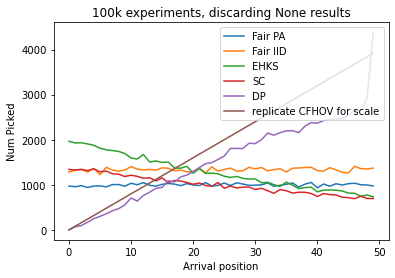

In [107]:
#Plotting the results for 100k experiments

arrivalPositionsChosenFairPA, a = runExperiment(algorithm="FairGeneralProphet", N_experimentReps=50000*2, 
                                                distribution_type="uniform", n_candidates=50)
    
arrivalPositionsChosenFairIID, b = runExperiment(algorithm="FairIIDProphet", N_experimentReps=50000*2, 
                                                distribution_type="uniform", n_candidates=50)
    
arrivalPositionsChosenSC, c = runExperiment(algorithm="SC", N_experimentReps=50000*2, 
                                                distribution_type="uniform", n_candidates=50)
    
arrivalPositionsChosenEHKS, d = runExperiment(algorithm="EHKS", N_experimentReps=50000*2, 
                                                distribution_type="uniform", n_candidates=50)

arrivalPositionsChosenDP, e = runExperiment(algorithm="DP", N_experimentReps=50000*2, 
                                                distribution_type="uniform", n_candidates=50)

### Average values of chosen candidates

In [90]:
print("The average value of the chosen candidate in the uniform distribution: \n")
print("FairPA: ", mean(a), "(should be 0.501)")
print("FairIID: ", mean(b), "(should be 0.661)")
print("SK: ", mean(c), "(should be 0.499)")
print("EHKS: ", mean(d), "(should be 0.631)")
print("SP: ", mean(e), "(should be 0.751)")

The average value of the chosen candidate in the uniform distribution: 

FairPA:  0.49667243056886534 (should be 0.501)
FairIID:  0.6601760666388474 (should be 0.661)
SK:  0.4956742604227484 (should be 0.499)
EHKS:  0.6265244037009832 (should be 0.631)
SP:  0.7526167376162972 (should be 0.751)



**Statement 1:** _In conclusion, for both settings, both our algorithms Algorithm 2 and Algorithm 3 provide perfect fairness, while giving 66.71% and 88.01% (for the uniform case), and 58.12% and 75.82% (for the binomial case), of the value of the optimal, but unfair, online algorithm._

Here the unfair online algorihtm must either SC or EHKS, something else is not mentioned about online algorithms. Also in the codebase, the unfair algorithms refer to these. Thus we will take a look at both, and see if these results are replicable.


In [91]:
print("Uniform case, for FairPA")
print("Assuming DP as the 'optimal, but unfair, online algorithm' :", mean(a) / mean(e) *100, "%")

print("\n Uniform case, for FairIID")
print("Assuming DP as the 'optimal, but unfair, online algorithm' :", mean(b) / mean(e) *100, "%")



Uniform case, for FairPA
Assuming DP as the 'optimal, but unfair, online algorithm' : 65.9927431513065 %

 Uniform case, for FairIID
Assuming DP as the 'optimal, but unfair, online algorithm' : 87.71743088384804 %


Both of these approaches thus do not (nearly) approach the results as presented in the paper, and seem to be verifiable in Figure 2 in the paper. Thus, the question is raised which algorithm is used to calculate the percentages mentioned in **Statement 1**.

## Binomial distribution

In [61]:
# arrivalPositionsChosenFairPA, FairPA_values = runExperiment(algorithm="FairGeneralProphet", N_experimentReps=50000, 
#                                                 distribution_type="binomial", n_candidates=1000)
# save('data/FairPA_positions.npy', arrivalPositionsChosenFairPA)
# save('data/FairPA_values.npy', FairPA_values)

100%|██████████| 50000/50000 [2:09:56<00:00,  6.41it/s]     


In [63]:
# arrivalPositionsChosenFairIID, FairIID_values = runExperiment(algorithm="FairIIDProphet", N_experimentReps=50000, 
#                                                 distribution_type="binomial", n_candidates=1000)
# save('data/FairIID_positions.npy', arrivalPositionsChosenFairIID)
# save('data/FairIID_values.npy', FairIID_values)

100%|██████████| 50000/50000 [1:24:04<00:00,  9.91it/s]


In [129]:
arrivalPositionsChosenSC, SC_values = runExperiment(algorithm="SC", N_experimentReps=2000, 
                                               distribution_type="binomial", n_candidates=1000)

save('data/SC_positions.npy', arrivalPositionsChosenSC)
save('data/SC_values.npy', SC_values)

arrivalPositionsChosenSC

100%|██████████| 2000/2000 [21:05<00:00,  1.58it/s] 


[2,
 2,
 1,
 0,
 2,
 2,
 2,
 4,
 1,
 2,
 2,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 3,
 2,
 3,
 0,
 1,
 1,
 1,
 4,
 1,
 0,
 3,
 1,
 2,
 4,
 0,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 7,
 2,
 1,
 2,
 1,
 1,
 0,
 0,
 3,
 0,
 1,
 1,
 2,
 3,
 2,
 0,
 1,
 3,
 2,
 3,
 1,
 0,
 1,
 4,
 1,
 2,
 1,
 1,
 0,
 2,
 0,
 0,
 0,
 1,
 0,
 3,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 2,
 3,
 3,
 0,
 2,
 1,
 0,
 0,
 2,
 0,
 0,
 2,
 2,
 0,
 1,
 3,
 1,
 3,
 2,
 0,
 2,
 0,
 1,
 0,
 0,
 2,
 0,
 2,
 2,
 1,
 1,
 2,
 4,
 1,
 1,
 3,
 3,
 3,
 2,
 0,
 1,
 3,
 1,
 2,
 0,
 1,
 0,
 3,
 1,
 2,
 2,
 1,
 0,
 2,
 2,
 1,
 0,
 3,
 2,
 2,
 1,
 4,
 1,
 0,
 2,
 1,
 2,
 2,
 2,
 1,
 3,
 0,
 2,
 0,
 0,
 1,
 4,
 1,
 0,
 0,
 1,
 0,
 4,
 1,
 1,
 2,
 0,
 2,
 2,
 0,
 3,
 2,
 3,
 1,
 2,
 0,
 1,
 0,
 1,
 2,
 0,
 3,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 2,
 3,
 1,
 0,
 2,
 2,
 2,
 1,
 3,
 2,
 1,
 3,
 0,
 2,
 1,
 0,
 0,
 1,
 1,
 2,
 1,
 2,
 2,
 3,
 2,
 0,
 0,
 1,
 1,
 2,
 0,
 3,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [64]:
# arrivalPositionsChosenEHKS, EHKS_values = runExperiment(algorithm="EHKS", N_experimentReps=50000, 
#                                                 distribution_type="binomial", n_candidates=1000)

# save('data/EHKS_positions.npy', arrivalPositionsChosenEHKS)
# save('data/EHKS_values.npy', EHKS_values)

100%|██████████| 50000/50000 [1:27:20<00:00,  9.54it/s]  


In [62]:
# arrivalPositionsChosenDP, DP_values = runExperiment(algorithm="DP", N_experimentReps=50000, 
#                                                 distribution_type="binomial", n_candidates=1000)

# save('data/DP_positions.npy', arrivalPositionsChosenDP)
# save('data/DP_values.npy', DP_values)

100%|██████████| 50000/50000 [2:55:37<00:00,  4.75it/s]      


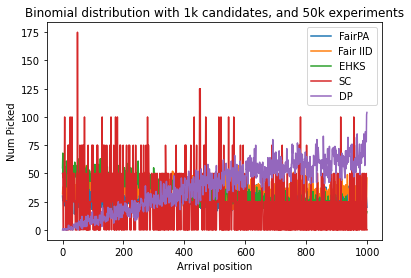

In [131]:
plt.plot(range(0,1000), load('data/FairPA_positions.npy'), label="FairPA")
plt.plot(range(0,1000), load('data/FairIID_positions.npy'), label="Fair IID")
plt.plot(range(0,1000), load('data/EHKS_positions.npy'), label="EHKS")
plt.plot(range(0,1000), load('data/SC_positions.npy')*25, label="SC")
plt.plot(range(0,1000), load('data/DP_positions.npy'), label="DP")
plt.xlabel("Arrival position")
plt.ylabel("Num Picked")
plt.title("Binomial distribution with 1k candidates, and 50k experiments")
plt.legend(loc="upper right")
plt.savefig("binomial.png")

In [99]:
arrivalPositionsChosenFairPA, FairPA_values = runExperiment(algorithm="FairGeneralProphet", N_experimentReps=50000*2, 
                                                distribution_type="binomial", n_candidates=100)
save('data/FairPA_positions100k.npy', arrivalPositionsChosenFairPA)
save('data/FairPA_values100k.npy', FairPA_values)

arrivalPositionsChosenFairIID, FairIID_values = runExperiment(algorithm="FairIIDProphet", N_experimentReps=50000, 
                                                distribution_type="binomial", n_candidates=1000)
save('data/FairIID_positions.npy', arrivalPositionsChosenFairIID)
save('data/FairIID_values.npy', FairIID_values)

# arrivalPositionsChosenSC, SC_values = runExperiment(algorithm="SC", N_experimentReps=1000, 
#                                                distribution_type="binomial", n_candidates=1000)

# save('data/SC_positions.npy', arrivalPositionsChosenSC)
# save('data/SC_values.npy', SC_values)

arrivalPositionsChosenEHKS, EHKS_values = runExperiment(algorithm="EHKS", N_experimentReps=50000, 
                                                distribution_type="binomial", n_candidates=1000)

save('data/EHKS_positions.npy', arrivalPositionsChosenEHKS)
save('data/EHKS_values.npy', EHKS_values)

# arrivalPositionsChosenDP, DP_values = runExperiment(algorithm="DP", N_experimentReps=50000, 
#                                                 distribution_type="binomial", n_candidates=1000)

# save('data/DP_positions.npy', arrivalPositionsChosenDP)
# save('data/DP_values.npy', DP_values)

 50%|████▉     | 49797/100000 [13:45<13:52, 60.30it/s]  


KeyboardInterrupt: 

## Extension

Don't need mathmathical underpinning! Just mention that it is possible/relevant.

  2%|▏         | 1104/50000 [00:00<00:04, 11034.07it/s]

Nonerate:  0.0 %
Average value of the chosen candidate with none’s as 0 value:  0.9544731863313253
Average value of the chosen candidate with None's excluded:  0.9544731863313253


  2%|▏         | 826/50000 [00:00<00:06, 8181.69it/s]

Nonerate:  20.192 %
Average value of the chosen candidate with none’s as 0 value:  0.7855453154604843
Average value of the chosen candidate with None's excluded:  0.9842939498051377


  4%|▍         | 2207/50000 [00:00<00:04, 11041.68it/s]

Nonerate:  33.48 %
Average value of the chosen candidate with none’s as 0 value:  0.6579810210758433
Average value of the chosen candidate with None's excluded:  0.9891476564579726


  2%|▏         | 1112/50000 [00:00<00:04, 11116.86it/s]

Nonerate:  42.828 %
Average value of the chosen candidate with none’s as 0 value:  0.5669473719922397
Average value of the chosen candidate with None's excluded:  0.9916521583856427


100%|██████████| 50000/50000 [00:04<00:00, 10945.01it/s]


Nonerate:  50.105999999999995 %
Average value of the chosen candidate with none’s as 0 value:  0.4955111269369442
Average value of the chosen candidate with None's excluded:  0.9931276845651665


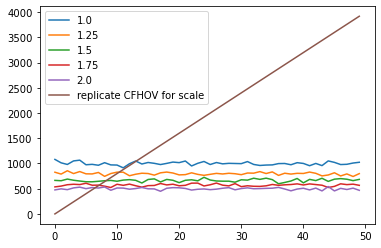

In [13]:
def FairGeneralProphetExtended(q, V, distribution_type, parameter_value):
    summ = 0.0
    for i in range(0,len(V)): #value < 1 reaches a drop!
        if V[i] >= Finv(distribution_type, (1.0 - (q[i] / (parameter_value - summ)))):
#         if V[i] >= Finv(distribution_type, (1- (q[i]/2)/(1-(summ/2)))):
            return i
        summ += q[i]

def FairIIDProphetExtended(Values, distribution_type, parameter_value):
    for i in range(0, len(Values)):
        p = (2.0 / 3.0) / len(Values)
        p = (2.0 / 2.0) / len(Values)
        if Values[i] >= Finv(distribution_type, (1.0 - p / (1.0 - p * i))):
            return i
        
def runExperimentExtended(algorithm, N_experimentReps, distribution_type, n_candidates, parameter_value):
    arrivalPositionsChosen, chosenValues, chosenValuesExcludeNone = [0]*n_candidates, [], []
    nones = 0
    for _ in tqdm(range(0, N_experimentReps)):
        q, Values = generateDistribution(distribution_type, n_candidates)
        
        if algorithm == "FairGeneralProphet":
                result = FairGeneralProphetExtended(q, Values, distribution_type, parameter_value)
        elif algorithm == "FairIIDProphet":
                result = FairIIDProphetExtended(Values, distribution_type, parameter_value)
        elif algorithm == "SC":
                result = SC_algorithm(Values, distribution_type)
        elif algorithm =="EHKS":
                result = EHKS_algorithm(Values, distribution_type)
        elif algorithm == "DP":
                result = DP_algorithm(Values, distribution_type)
        if result != None:
            arrivalPositionsChosen[result] += 1
            chosenValues.append(Values[result])
            chosenValuesExcludeNone.append(Values[result])
            
        if result == None: 
            chosenValues.append(0)
            nones += 1
            
        
    noneRate = nones/N_experimentReps
        
    return noneRate, mean(chosenValues), mean(chosenValuesExcludeNone), arrivalPositionsChosen

df = pd.DataFrame(columns=['Parameter value', 'Avg None=0', "Avg discard none"])
for param in [1.0, 1.25,1.5,1.75,2.0]:
    nonerate, avg_include, avg_exclude, chosen_positions = runExperimentExtended(algorithm="FairGeneralProphet", N_experimentReps=50000, 
                                                distribution_type="uniform", n_candidates=50, parameter_value=param)
    print("Nonerate: ", nonerate * 100, "%")
    print("Average value of the chosen candidate with none’s as 0 value: ", avg_include)
    print("Average value of the chosen candidate with None's excluded: ", avg_exclude)
    
    a_series = pd.Series([param,avg_include,avg_exclude], index = df.columns)
    df = df.append(a_series, ignore_index=True)
    
#     df = df.append([[param,avg_include,avg_exclude]], ignore_index=True)

    plt.plot(range(0,50), chosen_positions, label= str(param))
plt.plot(range(0,50), range(0,4000,80), label="replicate CFHOV for scale")
plt.legend()

In [54]:
import pandas as pd

In [73]:
df

,Parameter value,Avg None=0,Avg discard none
0,1.00,0.954140,0.954140
1,1.25,0.788429,0.984306
2,1.50,0.658641,0.989099
3,1.75,0.566516,0.991592
4,2.00,0.498878,0.993108


In [101]:
q, v = generateDistribution("binomial", 10)
v

array([482, 486, 503, 494, 526, 484, 484, 517, 497, 528])